# Build fastGRAHSP emulator model

The emulator is trained on "dumpfluxes" outputs by 
GRAHSP dualsampler.py. So first you need to make these files.

Next, two neural networks are trained on the galaxy and AGN fluxes
separately. Then they are fused into a single computational graph.


In [90]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from astropy.table import Table, vstack
import tqdm

## Load training data

In [3]:
fall = vstack([
    Table.read(f'model_fluxes_split_{i}.fits') for i in range(1, 29)])


In [4]:
fall.colnames

['log_sfhdelayed_tau_main',
 'log_sfhdelayed_age_main',
 'log_activatelines_AFeII',
 'log_activatelines_Alines',
 'activatelines.linewidth',
 'activategtorus.Si',
 'activategtorus.fcov',
 'activategtorus.COOLlam',
 'activategtorus.COOLwidth',
 'activategtorus.HOTlam',
 'activategtorus.HOTwidth',
 'log_activategtorus_HOTfcov',
 'activatepl.plslope',
 'activatepl.plbendloc',
 'log_activatepl_plbendwidth',
 'activatepl.uvslope',
 'log_biattenuation_E(B-V)',
 'log_biattenuation_E(B-V)-AGN',
 'galdale2014.alpha',
 'log_stellar_mass',
 'log_L_AGN',
 'redshift',
 'systematics',
 'sfh.sfr',
 'sfh.sfr10Myrs',
 'sfh.sfr100Myrs',
 'sfh.age',
 'stellar.lum',
 'dust.luminosity',
 'agn.lum12um',
 'agn.lum6um',
 'param.EW_K',
 'agn.lumBolBBB',
 'agn.lumBolTOR',
 'attenuation.ebv_agn',
 'attenuation.ebv',
 'NUV',
 'decam_g',
 'decam_r',
 'decam_i',
 'decam_z',
 'UV_Y',
 'UV_J',
 'UV_H',
 'UV_K',
 'WFCAM_Y',
 'WFCAM_J',
 'WFCAM_H',
 'WFCAM_Ks',
 'WISE1',
 'WISE2',
 'WISE3',
 'WISE4',
 'SUBARU_B',
 'SUB

In [5]:
del fall['param.EW_K']

In [6]:
#mask_visible = (
#    fall['AGN_WISE1'] + fall['AGN_WISE4'] + fall['AGN_NUV'] + fall['AGN_decam_g'] + fall['AGN_decam_z'] > 1e-6
#)
f = fall#[mask_visible]

In [7]:
print(len(f))

1090000


In [8]:
input_features = f[f.colnames[:f.colnames.index('systematics')]]

In [9]:
input_features['E(B-V)-total'] = 10**input_features['log_biattenuation_E(B-V)'] + 10**input_features['log_biattenuation_E(B-V)-AGN']

In [10]:
input_features.colnames

['log_sfhdelayed_tau_main',
 'log_sfhdelayed_age_main',
 'log_activatelines_AFeII',
 'log_activatelines_Alines',
 'activatelines.linewidth',
 'activategtorus.Si',
 'activategtorus.fcov',
 'activategtorus.COOLlam',
 'activategtorus.COOLwidth',
 'activategtorus.HOTlam',
 'activategtorus.HOTwidth',
 'log_activategtorus_HOTfcov',
 'activatepl.plslope',
 'activatepl.plbendloc',
 'log_activatepl_plbendwidth',
 'activatepl.uvslope',
 'log_biattenuation_E(B-V)',
 'log_biattenuation_E(B-V)-AGN',
 'galdale2014.alpha',
 'log_stellar_mass',
 'log_L_AGN',
 'redshift',
 'E(B-V)-total']

Amplitude-like parameters which can only increase fluxes:

In [11]:
input_features_keep_AGN = [c for c in input_features.colnames if ('activate' in c or 'AGN' in c or 'E(B-V)' in c or 'redshift' in c) and 'log_biattenuation_E' not in c]
input_features_keep_GAL = [c for c in input_features.colnames if 'activate' not in c and 'AGN' not in c and 'E(B-V)-total' not in c]

In [12]:
input_features_keep_GAL

['log_sfhdelayed_tau_main',
 'log_sfhdelayed_age_main',
 'log_biattenuation_E(B-V)',
 'galdale2014.alpha',
 'log_stellar_mass',
 'redshift']

In [13]:
input_features_keep_AGN

['log_activatelines_AFeII',
 'log_activatelines_Alines',
 'activatelines.linewidth',
 'activategtorus.Si',
 'activategtorus.fcov',
 'activategtorus.COOLlam',
 'activategtorus.COOLwidth',
 'activategtorus.HOTlam',
 'activategtorus.HOTwidth',
 'log_activategtorus_HOTfcov',
 'activatepl.plslope',
 'activatepl.plbendloc',
 'log_activatepl_plbendwidth',
 'activatepl.uvslope',
 'log_L_AGN',
 'redshift',
 'E(B-V)-total']

In [14]:
output_columns = f.colnames[f.colnames.index('systematics')+1:]

In [15]:
output_columns = output_columns[:output_columns.index('NUV')] + [c for c in output_columns if 'GAL_' in c or 'AGN_' in c]

In [16]:
len(output_columns), len(input_features.colnames)

(110, 23)

In [17]:
output_features = f[output_columns]

In [18]:
output_features.to_pandas().describe().transpose()

,count,mean,std,min,25%,50%,75%,max
sfh.sfr,1090000.0,1.856061e+02,7.484197e+02,7.188487e-40,4.039607e-03,2.692637e-01,1.983758e+01,1.233085e+04
sfh.sfr10Myrs,1090000.0,1.837347e+02,7.373069e+02,7.518554e-40,4.036958e-03,2.690310e-01,1.980885e+01,1.198531e+04
sfh.sfr100Myrs,1090000.0,1.631266e+02,6.203159e+02,1.220983e-39,3.991140e-03,2.646108e-01,1.930529e+01,8.559402e+03
sfh.age,1090000.0,1.257257e+03,1.371169e+03,1.580000e+02,3.490000e+02,7.400000e+02,1.633000e+03,9.793000e+03
stellar.lum,1090000.0,7.580289e+38,2.864625e+39,1.257121e+31,3.500708e+34,1.994437e+36,1.118068e+38,4.342259e+40
dust.luminosity,1090000.0,5.042633e+38,2.127456e+39,2.319726e+29,1.729662e+34,9.863810e+35,5.679677e+37,4.144507e+40
agn.lum12um,1090000.0,6.368382e+38,2.218971e+39,1.251973e+30,1.936594e+33,3.444295e+35,6.123224e+37,2.473750e+40
agn.lum6um,1090000.0,8.125966e+38,6.040463e+39,1.521597e+28,1.337439e+33,2.391749e+35,4.226002e+37,9.429467e+41
agn.lumBolBBB,1090000.0,5.780393e+39,2.144040e+40,3.649468e+31,1.786333e+34,3.176575e+36,5.607345e+38,4.867680e+41
agn.lumBolTOR,1090000.0,4.865114e+39,5.982156e+40,1.420848e+30,9.379097e+33,1.663418e+36,2.957322e+38,1.784145e+43


In [19]:
del output_features[['sfh.age', 'dust.luminosity', 'attenuation.ebv_agn', 'attenuation.ebv']]

In [20]:
input_features_AGN = input_features[input_features_keep_AGN]
del input_features_AGN['log_L_AGN']

In [21]:
input_features_AGN.to_pandas().describe().transpose()

,count,mean,std,min,25%,50%,75%,max
log_activatelines_AFeII,1090000.0,0.646517,0.493048,-0.200000,0.223724,6.457457e-01,1.066066,1.500000
log_activatelines_Alines,1090000.0,0.597318,0.521068,-0.300000,0.152252,5.954955e-01,1.045946,1.500000
activatelines.linewidth,1090000.0,5244.408857,2751.640015,400.000000,2926.315789,5.260150e+03,7642.105263,10000.000000
activategtorus.Si,1090000.0,0.069291,2.342783,-4.000000,-1.980000,6.000000e-02,2.100000,4.080000
activategtorus.fcov,1090000.0,0.527356,0.272911,0.050000,0.290000,5.300000e-01,0.760000,0.990000
activategtorus.COOLlam,1090000.0,19.959068,5.786633,10.000000,14.950000,2.000000e+01,25.010000,29.990000
activategtorus.COOLwidth,1090000.0,0.441312,0.147521,0.200000,0.310000,4.400000e-01,0.570000,0.690000
activategtorus.HOTlam,1090000.0,3.239271,1.306964,1.000000,2.100000,3.250000e+00,4.370000,5.500000
activategtorus.HOTwidth,1090000.0,0.446696,0.144504,0.200000,0.320000,4.500000e-01,0.570000,0.690000
log_activategtorus_HOTfcov,1090000.0,-0.243913,1.014755,-2.000000,-1.105263,-2.456140e-01,0.622807,1.500000


In [22]:
input_features_GAL = input_features[input_features_keep_GAL]
del input_features_GAL['log_stellar_mass']


In [23]:
AGN_output_colnames = []
AGN_output_z = []
GAL_output_colnames = []
GAL_output_z = []
for colname in output_features.colnames:
    if colname.lower().startswith('agn'):
        if colname.startswith('agn.'):
            continue
        AGN_output_z.append(output_features[colname] / 10**(input_features['log_L_AGN'] - 44))
        AGN_output_colnames.append(colname)
    else:
        GAL_output_z.append(output_features[colname] / 10**(input_features['log_stellar_mass'] - 10))
        GAL_output_colnames.append(colname)

AGN_output_z = np.transpose(AGN_output_z)
GAL_output_z = np.transpose(GAL_output_z)

In [24]:
AGN_output_colnames

['AGN_NUV',
 'AGN_decam_g',
 'AGN_decam_r',
 'AGN_decam_i',
 'AGN_decam_z',
 'AGN_UV_Y',
 'AGN_UV_J',
 'AGN_UV_H',
 'AGN_UV_K',
 'AGN_WFCAM_Y',
 'AGN_WFCAM_J',
 'AGN_WFCAM_H',
 'AGN_WFCAM_Ks',
 'AGN_WISE1',
 'AGN_WISE2',
 'AGN_WISE3',
 'AGN_WISE4',
 'AGN_SUBARU_B',
 'AGN_SUBARU_V',
 'AGN_SUBARU_r',
 'AGN_SUBARU_i',
 'AGN_SUBARU_z',
 'AGN_CFHT_H',
 'AGN_CFHT_K',
 'AGN_HSC_y',
 'AGN_IB427_SCam',
 'AGN_IB464_SCam',
 'AGN_IB484_SCam',
 'AGN_IB505_SCam',
 'AGN_IB527_SCam',
 'AGN_IB574_SCam',
 'AGN_IB624_SCam',
 'AGN_IB679_SCam',
 'AGN_IB709_SCam',
 'AGN_IB738_SCam',
 'AGN_IB767_SCam',
 'AGN_IB827_SCam',
 'AGN_NB711_SCam',
 'AGN_NB816_SCam',
 'AGN_IRAC1',
 'AGN_IRAC2',
 'AGN_IRAC3',
 'AGN_IRAC4',
 'AGN_MIPS1',
 'AGN_PACS_green',
 'AGN_PACS_red',
 'AGN_PSW',
 'AGN_PMW',
 'AGN_PLW']

In [25]:
GAL_output_colnames

['sfh.sfr',
 'sfh.sfr10Myrs',
 'sfh.sfr100Myrs',
 'stellar.lum',
 'GAL_NUV',
 'GAL_decam_g',
 'GAL_decam_r',
 'GAL_decam_i',
 'GAL_decam_z',
 'GAL_UV_Y',
 'GAL_UV_J',
 'GAL_UV_H',
 'GAL_UV_K',
 'GAL_WFCAM_Y',
 'GAL_WFCAM_J',
 'GAL_WFCAM_H',
 'GAL_WFCAM_Ks',
 'GAL_WISE1',
 'GAL_WISE2',
 'GAL_WISE3',
 'GAL_WISE4',
 'GAL_SUBARU_B',
 'GAL_SUBARU_V',
 'GAL_SUBARU_r',
 'GAL_SUBARU_i',
 'GAL_SUBARU_z',
 'GAL_CFHT_H',
 'GAL_CFHT_K',
 'GAL_HSC_y',
 'GAL_IB427_SCam',
 'GAL_IB464_SCam',
 'GAL_IB484_SCam',
 'GAL_IB505_SCam',
 'GAL_IB527_SCam',
 'GAL_IB574_SCam',
 'GAL_IB624_SCam',
 'GAL_IB679_SCam',
 'GAL_IB709_SCam',
 'GAL_IB738_SCam',
 'GAL_IB767_SCam',
 'GAL_IB827_SCam',
 'GAL_NB711_SCam',
 'GAL_NB816_SCam',
 'GAL_IRAC1',
 'GAL_IRAC2',
 'GAL_IRAC3',
 'GAL_IRAC4',
 'GAL_MIPS1',
 'GAL_PACS_green',
 'GAL_PACS_red',
 'GAL_PSW',
 'GAL_PMW',
 'GAL_PLW']

In [26]:
from sklearn.model_selection import train_test_split

In [27]:
from sklearn.metrics import r2_score

In [28]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout, Input, Normalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import StandardScaler

2025-06-10 05:41:10.208464: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-06-10 05:41:10.471458: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1749526870.583318  763614 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1749526870.605871  763614 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1749526870.769988  763614 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [29]:
from tensorflow.keras.layers import Lambda
import tensorflow.keras.backend as K

In [30]:
import tensorflow as tf

In [31]:
import tf2onnx

In [32]:
import onnxruntime as rt

## Train on GAL output columns

In [33]:
width = 512

In [34]:
input_z_array = np.asarray(input_features_GAL).view((float, len(input_features_GAL.colnames)))
output_z_array = GAL_output_z

In [35]:
X_train, X_test, y_train, y_test = train_test_split(input_z_array, output_z_array, random_state=42)

In [36]:
X_train.shape, y_train.shape

((817500, 5), (817500, 53))

In [37]:
gnorm = Normalization()
gnorm.adapt(input_z_array)

2025-06-10 05:41:17.682187: E external/local_xla/xla/stream_executor/cuda/cuda_platform.cc:51] failed call to cuInit: INTERNAL: CUDA error: Failed call to cuInit: UNKNOWN ERROR (303)


In [38]:
gmodel = Sequential([
    Input((X_train.shape[1],)),
    gnorm,
    Dense(width, activation='relu'),
    Dense(width, activation='relu'),
    Dense(y_train.shape[1])  # Output: logflux
])
gmodel.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
# Early stopping to prevent overfitting
early_stop = EarlyStopping(patience=10, restore_best_weights=True, min_delta=0.0001, verbose=1)
gmodel.fit(X_train, np.log10(y_train + 1e-10), epochs=50, batch_size=512, validation_split=0.2, callbacks=[early_stop])


Epoch 1/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 6.0443 - val_loss: 0.0948
Epoch 2/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0731 - val_loss: 0.0395
Epoch 3/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0357 - val_loss: 0.0289
Epoch 4/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0265 - val_loss: 0.0226
Epoch 5/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0207 - val_loss: 0.0176
Epoch 6/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0165 - val_loss: 0.0161
Epoch 7/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 9s 7ms/step - loss: 0.0139 - val_loss: 0.0121
Epoch 8/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0119 - val_loss: 0.0108
Epoch 9/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0105 - val_loss: 0.0108
Epoch 10/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 8s 7ms/step - loss: 0.0095 - val_loss: 0.0091
Epoch 11/50
1278/1278 ━━━━━━━━━━━━━━━━━━━━ 8s 6ms/step - loss: 0.0088 - val_loss: 0.0095
Epoch 12/50
1278/1278 ━━━━━━━

In [39]:
y_test_pred = gmodel.predict(X_test)

8516/8516 ━━━━━━━━━━━━━━━━━━━━ 6s 710us/step


In [40]:
r2_score(y_test_pred, np.log10(y_test + 1e-10))

0.9989449085808572

In [41]:
len(GAL_output_colnames), gmodel.outputs[0].shape

(53, (None, 53))

In [42]:
gmodel.output_names = ['GAL_outputs']

In [43]:
gmodel.inputs[0]

<KerasTensor shape=(None, 5), dtype=float32, sparse=False, ragged=False, name=keras_tensor>

In [44]:
gmodel.inputs

[<KerasTensor shape=(None, 5), dtype=float32, sparse=False, ragged=False, name=keras_tensor>]

In [45]:
input_signature = [tf.TensorSpec(gmodel.inputs[0].shape, gmodel.inputs[0].dtype, name='GAL_inputs')]

In [46]:
with open(f'nn_emulator/GAL{width}.txt', 'w') as fout:
    fout.write("\n".join(GAL_output_colnames) + "\n")

In [47]:
tf2onnx.convert.from_keras(gmodel, input_signature=input_signature, output_path=f'nn_emulator/GAL{width}.onnx', opset=10);

I0000 00:00:1749527323.262544  763614 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1749527323.263123  763614 single_machine.cc:374] Starting new session
I0000 00:00:1749527323.361104  763614 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1749527323.361369  763614 single_machine.cc:374] Starting new session


In [48]:
!du -sk nn_emulator/GAL*.onnx

101	nn_emulator/GAL128.onnx
329	nn_emulator/GAL256.onnx
1161	nn_emulator/GAL512.onnx
209	nn_emulator/GALAGN128.onnx
657	nn_emulator/GALAGN256.onnx
2321	nn_emulator/GALAGN512.onnx
105	nn_emulator/GAL.onnx


In [49]:
session = sess = rt.InferenceSession(f'nn_emulator/GAL{width}.onnx', providers=["CPUExecutionProvider"])
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
y_test_pred = session.run([label_name], {input_name: X_test.astype(np.float32)})[0]

In [50]:
X_test.shape

(272500, 5)

In [51]:
y_test_pred.shape

(272500, 53)

Plot quality of approximation

In [52]:
i = GAL_output_colnames.index('GAL_IB527_SCam')

/tmp/ipykernel_763614/3020879479.py:1: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(y_test[:,i], 10**y_test_pred[:,i] / y_test[:,i], s=0.5, alpha=0.1)


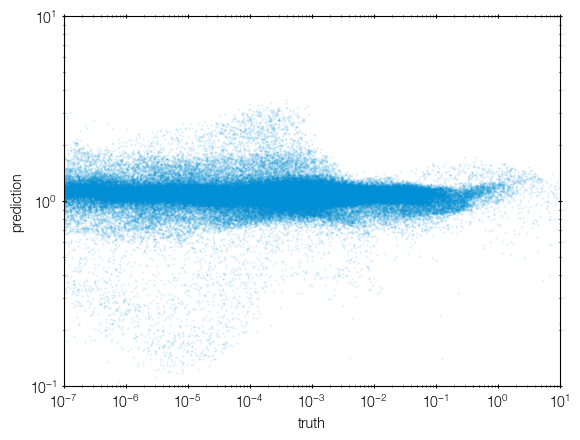

In [53]:
plt.scatter(y_test[:,i], 10**y_test_pred[:,i] / y_test[:,i], s=0.5, alpha=0.1)
plt.xlabel('truth')
plt.ylabel('prediction')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-1, 1e1);
plt.xlim(1e-7, 10);


/tmp/ipykernel_763614/381034841.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.hist(y_test_pred[:,i] - np.log10(y_test[:,i]), bins=np.linspace(-1, 1, 40), histtype='step', label=colname)
/tmp/ipykernel_763614/381034841.py:2: RuntimeWarning: invalid value encountered in log10
  plt.hist(y_test_pred[:,i] - np.log10(y_test[:,i]), bins=np.linspace(-1, 1, 40), histtype='step', label=colname)


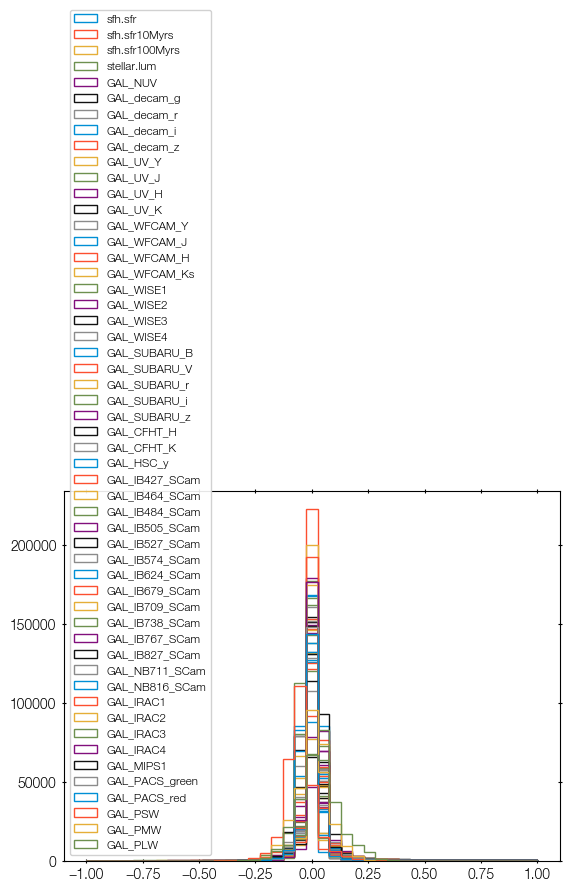

In [54]:
for i, colname in enumerate(GAL_output_colnames):
    plt.hist(y_test_pred[:,i] - np.log10(y_test[:,i]), bins=np.linspace(-1, 1, 40), histtype='step', label=colname)
plt.legend();

## Train on AGN output columns

In [55]:
input_z_array = np.asarray(input_features_AGN).view((float, len(input_features_AGN.colnames)))
output_z_array = AGN_output_z

In [56]:
X_train, X_test, y_train, y_test = train_test_split(input_z_array, output_z_array, random_state=42)

In [57]:
X_train.shape, y_train.shape

((817500, 16), (817500, 49))

In [58]:
anorm = Normalization()
anorm.adapt(input_z_array)

In [59]:
amodel = Sequential([
    Input((X_train.shape[1],)),
    anorm,
    Dense(width, activation='relu'),
    Dense(width, activation='relu'),
    Dense(y_train.shape[1])  # Output: logflux
])
amodel.compile(optimizer=Adam(learning_rate=1e-3), loss='mse')
# Early stopping to prevent overfitting
early_stop = EarlyStopping(patience=10, restore_best_weights=True, min_delta=0.0001, verbose=1)
amodel.fit(X_train, np.log10(y_train + 1e-10), epochs=50, batch_size=128, validation_split=0.2, callbacks=[early_stop])


Epoch 1/50
5110/5110 ━━━━━━━━━━━━━━━━━━━━ 16s 3ms/step - loss: 1.7169 - val_loss: 0.0507
Epoch 2/50
5110/5110 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.0430 - val_loss: 0.0368
Epoch 3/50
5110/5110 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.0301 - val_loss: 0.0268
Epoch 4/50
5110/5110 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.0250 - val_loss: 0.0244
Epoch 5/50
5110/5110 ━━━━━━━━━━━━━━━━━━━━ 18s 4ms/step - loss: 0.0222 - val_loss: 0.0206
Epoch 6/50
5110/5110 ━━━━━━━━━━━━━━━━━━━━ 19s 4ms/step - loss: 0.0202 - val_loss: 0.0190
Epoch 7/50
5110/5110 ━━━━━━━━━━━━━━━━━━━━ 23s 5ms/step - loss: 0.0187 - val_loss: 0.0175
Epoch 8/50
5110/5110 ━━━━━━━━━━━━━━━━━━━━ 21s 4ms/step - loss: 0.0174 - val_loss: 0.0167
Epoch 9/50
5110/5110 ━━━━━━━━━━━━━━━━━━━━ 18s 3ms/step - loss: 0.0159 - val_loss: 0.0164
Epoch 10/50
5110/5110 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.0149 - val_loss: 0.0153
Epoch 11/50
5110/5110 ━━━━━━━━━━━━━━━━━━━━ 15s 3ms/step - loss: 0.0140 - val_loss: 0.0133
Epoch 12/50
5110/51

In [60]:
y_test_pred = amodel.predict(X_test)

8516/8516 ━━━━━━━━━━━━━━━━━━━━ 6s 721us/step


In [61]:
y_test_pred.shape, y_test.shape

((272500, 49), (272500, 49))

In [62]:
r2_score(y_test_pred, np.log10(y_test + 1e-10))

0.9986091929171702

In [63]:
len(AGN_output_colnames), len(amodel.outputs)

(49, 1)

In [64]:
amodel.output_names = ['AGN_outputs']

In [65]:
amodel.inputs[0]

<KerasTensor shape=(None, 16), dtype=float32, sparse=False, ragged=False, name=keras_tensor_5>

In [66]:
amodel.inputs

[<KerasTensor shape=(None, 16), dtype=float32, sparse=False, ragged=False, name=keras_tensor_5>]

In [67]:
input_signature = [tf.TensorSpec(amodel.inputs[0].shape, amodel.inputs[0].dtype, name='AGN_inputs')]

In [68]:
with open(f'nn_emulator/AGN{width}.txt', 'w') as fout:
    fout.write("\n".join(AGN_output_colnames) + "\n")

In [69]:
tf2onnx.convert.from_keras(amodel, input_signature=input_signature, output_path=f'nn_emulator/AGN{width}.onnx', opset=10);

I0000 00:00:1749528160.830829  763614 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1749528160.831418  763614 single_machine.cc:374] Starting new session
I0000 00:00:1749528161.145873  763614 devices.cc:67] Number of eligible GPUs (core count >= 8, compute capability >= 0.0): 0
I0000 00:00:1749528161.146002  763614 single_machine.cc:374] Starting new session


In [70]:
!du -sk nn_emulator/AGN*.onnx

101	nn_emulator/AGN128.onnx
337	nn_emulator/AGN256.onnx
1173	nn_emulator/AGN512.onnx


In [71]:
session = sess = rt.InferenceSession(f'nn_emulator/AGN{width}.onnx', providers=["CPUExecutionProvider"])
input_name = sess.get_inputs()[0].name
label_name = sess.get_outputs()[0].name
y_test_pred = session.run([label_name], {input_name: X_test.astype(np.float32)})[0]

In [72]:
X_test.shape

(272500, 16)

In [73]:
y_test_pred.shape

(272500, 49)

Plot quality of approximation

In [74]:
i = AGN_output_colnames.index('AGN_IB527_SCam')

/tmp/ipykernel_763614/3035168662.py:2: RuntimeWarning: divide by zero encountered in divide
  plt.scatter(y_test[:,i], 10**y_test_pred[:,i] / y_test[:,i], s=0.5, alpha=0.1)


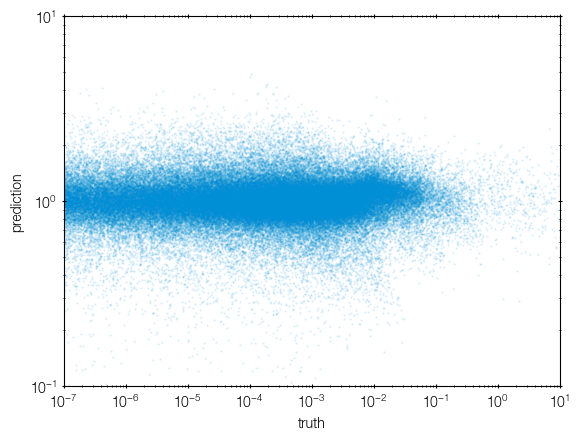

In [75]:
#plt.scatter(y_test, 10**rf.predict(X_test) / y_test, s=0.5, alpha=0.1)
plt.scatter(y_test[:,i], 10**y_test_pred[:,i] / y_test[:,i], s=0.5, alpha=0.1)
#plt.plot([1e-6, 1e3], [1e-6, 1e3], '--')
plt.xlabel('truth')
plt.ylabel('prediction')
plt.yscale('log')
plt.xscale('log')
plt.ylim(1e-1, 1e1);
plt.xlim(1e-7, 10);


/tmp/ipykernel_763614/113180596.py:2: RuntimeWarning: divide by zero encountered in log10
  plt.hist(y_test_pred[:,i] - np.log10(y_test[:,i]), bins=np.linspace(-1, 1, 40), histtype='step', label=colname)
/tmp/ipykernel_763614/113180596.py:2: RuntimeWarning: invalid value encountered in log10
  plt.hist(y_test_pred[:,i] - np.log10(y_test[:,i]), bins=np.linspace(-1, 1, 40), histtype='step', label=colname)


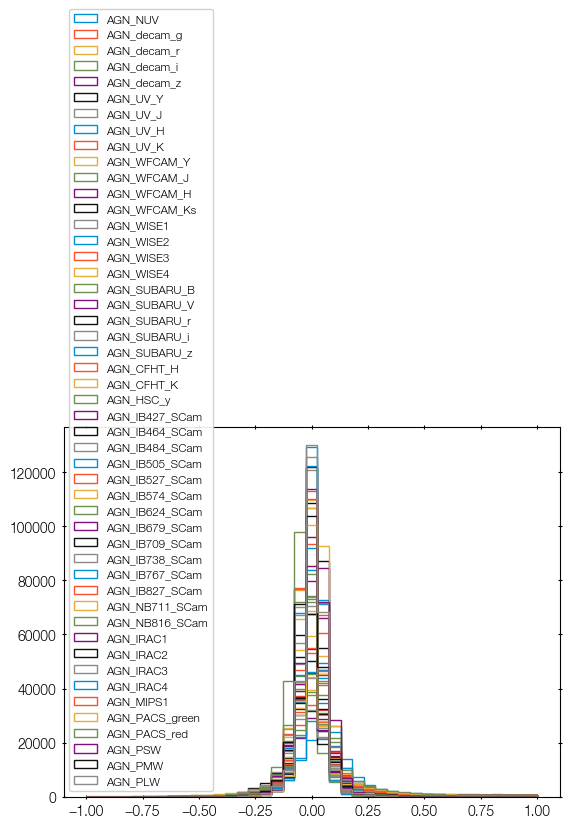

In [76]:
for i, colname in enumerate(AGN_output_colnames):
    plt.hist(y_test_pred[:,i] - np.log10(y_test[:,i]), bins=np.linspace(-1, 1, 40), histtype='step', label=colname)
plt.legend();

## Export as a single neural network

In [77]:
GAL_norm_index = input_features.colnames.index('log_stellar_mass')
AGN_norm_index = input_features.colnames.index('log_L_AGN')
GAL_arg_indices = np.array([c in input_features_keep_GAL and c != 'log_stellar_mass' for c in input_features.colnames])
AGN_arg_indices = np.array([c in input_features_keep_AGN and c != 'log_L_AGN' for c in input_features.colnames])


In [78]:
assert GAL_arg_indices.sum() == 5
assert AGN_arg_indices.sum() == 16


In [79]:
def build_input_and_feature_extractors():
    """Create nodes that split the full input features into what the GAL/AGN emulators need. """
    input_tensor = oh.make_tensor_value_info("X", onnx.TensorProto.FLOAT, [None, int(len(GAL_arg_indices))])

    # Define constants for feature indices
    gal_indices = np.where(GAL_arg_indices)[0].astype(np.int64)
    agn_indices = np.where(AGN_arg_indices)[0].astype(np.int64)

    # Create initializer tensors
    gal_indices_initializer = np_helper.from_array(gal_indices, name="GAL_indices")
    agn_indices_initializer = np_helper.from_array(agn_indices, name="AGN_indices")

    # Gather nodes
    gal_gather = oh.make_node(
        "Gather", inputs=["X", "GAL_indices"], outputs=["Xgal"], axis=1
    )
    agn_gather = oh.make_node(
        "Gather", inputs=["X", "AGN_indices"], outputs=["Xagn"], axis=1
    )
    gal_input_tensor = oh.make_tensor_value_info("Xgal", onnx.TensorProto.FLOAT, [None, int(GAL_arg_indices.sum())])
    agn_input_tensor = oh.make_tensor_value_info("Xagn", onnx.TensorProto.FLOAT, [None, int(AGN_arg_indices.sum())])
    return input_tensor, (gal_input_tensor, agn_input_tensor), [gal_indices_initializer, agn_indices_initializer], [gal_gather, agn_gather]

def build_norm_extraction_nodes():
    """Create nodes that get the log-normalisations. """
    norm_gal_idx = np.array([GAL_norm_index if GAL_norm_index >= 0 else 24 + GAL_norm_index], dtype=np.int64)
    norm_agn_idx = np.array([AGN_norm_index if AGN_norm_index >= 0 else 24 + AGN_norm_index], dtype=np.int64)

    gal_norm_idx_init = np_helper.from_array(norm_gal_idx, name="gal_norm_index")
    agn_norm_idx_init = np_helper.from_array(norm_agn_idx, name="agn_norm_index")

    gal_norm_gather = oh.make_node("Gather", inputs=["X", "gal_norm_index"], outputs=["gal_norm_raw"], axis=1)
    agn_norm_gather = oh.make_node("Gather", inputs=["X", "agn_norm_index"], outputs=["agn_norm_raw"], axis=1)

    # Constants for offset
    gal_offset_init = np_helper.from_array(np.array([10.0], dtype=np.float32), name="gal_norm_offset")
    agn_offset_init = np_helper.from_array(np.array([44.0], dtype=np.float32), name="agn_norm_offset")
    # Subtract offsets
    gal_sub = oh.make_node("Sub", inputs=["gal_norm_raw", "gal_norm_offset"], outputs=["gal_norm_adj"])
    agn_sub = oh.make_node("Sub", inputs=["agn_norm_raw", "agn_norm_offset"], outputs=["agn_norm_adj"])

    gal_norm = oh.make_node("Pow", inputs=["ten", "gal_norm_adj"], outputs=["gal_norm"])
    agn_norm = oh.make_node("Pow", inputs=["ten", "agn_norm_adj"], outputs=["agn_norm"])

    return [gal_norm_idx_init, agn_norm_idx_init, gal_offset_init, agn_offset_init], [
        gal_norm_gather, agn_norm_gather, gal_sub, agn_sub, gal_norm, agn_norm
    ]


def build_output_extraction_nodes(GAL_arg_mask, AGN_arg_mask):
    """Create nodes that get the log-normalisations. """
    # Define constants for feature indices
    gal_indices = np.where(GAL_arg_mask)[0].astype(np.int64)
    agn_indices = np.where(AGN_arg_mask)[0].astype(np.int64)

    # Create initializer tensors
    gal_indices_initializer = np_helper.from_array(gal_indices, name="GAL_outputs_indices")
    agn_indices_initializer = np_helper.from_array(agn_indices, name="AGN_outputs_indices")

    # Gather nodes
    gal_gather = oh.make_node(
        "Gather", inputs=["GAL_outputs_linear_scaled", "GAL_outputs_indices"], outputs=["GAL_outputs_selected"], axis=1
    )
    agn_gather = oh.make_node(
        "Gather", inputs=["AGN_outputs_linear_scaled", "AGN_outputs_indices"], outputs=["AGN_outputs_selected"], axis=1
    )
    return [gal_indices_initializer, agn_indices_initializer], [gal_gather, agn_gather]

def build_gal_output_node(gal_output_name, model_output_name):
    """Create a GAL emulator linear flux output node."""
    pow10_node = oh.make_node("Pow", inputs=["ten", model_output_name], outputs=[model_output_name + "_linear"])
    mul_node = oh.make_node("Mul", inputs=[model_output_name + "_linear", "gal_norm"], outputs=[gal_output_name])
    return [pow10_node, mul_node]

def build_agn_output_node(agn_output_name, model_output_name):
    """Create a AGN emulator linear flux output node."""
    pow10_node = oh.make_node("Pow", inputs=["ten", model_output_name], outputs=[model_output_name + "_linear"])
    mul_node = oh.make_node("Mul", inputs=[model_output_name + "_linear", "agn_norm"], outputs=[agn_output_name])
    return [pow10_node, mul_node]

def build_both_output_node(output_name, gal_val="gal_pred", agn_val="agn_pred"):
    """Create a total linear flux output node (AGN+GAL)."""
    nodes = [
        oh.make_node("Add", inputs=[gal_val, agn_val], outputs=[output_name])
    ]
    return nodes


In [80]:
import onnxruntime as rt
import onnx
import onnx.helper as oh
import onnx.numpy_helper as np_helper
from onnx import compose
import onnxsim
from onnxsim.model_info import print_simplifying_info


In [81]:
GALfilename = f'nn_emulator/GAL{width}'
AGNfilename = f'nn_emulator/AGN{width}'
GAL = onnx.load(GALfilename + '.onnx')
AGN = onnx.load(AGNfilename + '.onnx')
# get output column names
GALcolnames = list([line.strip() for line in open(GALfilename + '.txt')])
AGNcolnames = list([line.strip() for line in open(AGNfilename + '.txt')])
colnames = [colname.replace('GAL_', '') for colname in GALcolnames if colname.replace('GAL_', 'AGN_') in AGNcolnames]
GALsharedmask = np.array([colname.replace('GAL_', '') in colnames for colname in GALcolnames])
AGNsharedmask = np.array([colname.replace('AGN_', '') in colnames for colname in AGNcolnames])
GALsharedindices = np.array([i for i, colname in enumerate(GALcolnames) if colname.replace('GAL_', '') in colnames])
AGNsharedindices = np.array([i for i, colname in enumerate(AGNcolnames) if colname.replace('AGN_', '') in colnames])
print("  total flux emulator can output:", colnames)


  total flux emulator can output: ['NUV', 'decam_g', 'decam_r', 'decam_i', 'decam_z', 'UV_Y', 'UV_J', 'UV_H', 'UV_K', 'WFCAM_Y', 'WFCAM_J', 'WFCAM_H', 'WFCAM_Ks', 'WISE1', 'WISE2', 'WISE3', 'WISE4', 'SUBARU_B', 'SUBARU_V', 'SUBARU_r', 'SUBARU_i', 'SUBARU_z', 'CFHT_H', 'CFHT_K', 'HSC_y', 'IB427_SCam', 'IB464_SCam', 'IB484_SCam', 'IB505_SCam', 'IB527_SCam', 'IB574_SCam', 'IB624_SCam', 'IB679_SCam', 'IB709_SCam', 'IB738_SCam', 'IB767_SCam', 'IB827_SCam', 'NB711_SCam', 'NB816_SCam', 'IRAC1', 'IRAC2', 'IRAC3', 'IRAC4', 'MIPS1', 'PACS_green', 'PACS_red', 'PSW', 'PMW', 'PLW']


In [82]:
Xfull = np.asarray(input_features).view((float, len(input_features.colnames)))

In [83]:
# some helper nodes for computation
# nodes for extracting only the relevant input parameters for each network
input_tensor, (gal_input_tensor, agn_input_tensor), gather_initializers, gather_nodes = build_input_and_feature_extractors()
# networks give the ratio to a normalisation; these nodes get the normalisation parameters
norm_initializers, norm_nodes = build_norm_extraction_nodes()
# for power of ten
ten_init = np_helper.from_array(np.array([10.0], dtype=np.float32), name="ten")
# nodes for the sum of fluxes, which is not applicable to all outputs (only those that are fluxes).
output_gather_initializers, output_gather_nodes = build_output_extraction_nodes(GALsharedmask, AGNsharedmask)
output_tensor = oh.make_tensor_value_info('both_val', onnx.TensorProto.FLOAT, [None, len(colnames)])

# create a small graph that splits the input into something the two neural networks can understand
base_model = oh.make_model(
    graph=oh.make_graph(
        name="SplitterGraph",
        inputs=[input_tensor],
        outputs=[gal_input_tensor, agn_input_tensor],
        initializer=[ten_init] + gather_initializers + norm_initializers + output_gather_initializers,
        nodes=gather_nodes + norm_nodes,
    ),
    opset_imports=[onnx.helper.make_opsetid("", 10)],  # Match opset version
    ir_version=5  # Match IR version of submodels
)
# merge them
merged = compose.merge_models(compose.merge_models(
    base_model,
    GAL, io_map=(('Xgal', GAL.graph.input[0].name),)),
    AGN, io_map=(('Xagn', AGN.graph.input[0].name),))
# now we need to post-process the output:
# make nodes that scale the output with the normalising factor (stellar mass or LAGN)
merged.graph.node.extend(build_gal_output_node("GAL_outputs_linear_scaled", "GAL_outputs"))
merged.graph.node.extend(build_agn_output_node("AGN_outputs_linear_scaled", "AGN_outputs"))
# then sum the results together
merged.graph.node.extend(output_gather_nodes)
merged.graph.node.extend(build_both_output_node('both_val', "GAL_outputs_selected", "AGN_outputs_selected"))
del merged.graph.output[:]
# we keep three outputs
merged.graph.output.extend([
    oh.make_tensor_value_info('GAL_outputs_linear_scaled', onnx.TensorProto.FLOAT, [None, len(GALcolnames)]),
    oh.make_tensor_value_info('AGN_outputs_linear_scaled', onnx.TensorProto.FLOAT, [None, len(AGNcolnames)]),
    output_tensor,
])
onnx.checker.check_model(merged)
fused, check = onnxsim.simplify(merged, input_data=Xfull)
print_simplifying_info(merged, fused)
assert check
onnx.save(fused, f'nn_emulator/GALAGN{width}.onnx')

┏━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━┓
┃            ┃ Original Model ┃ Simplified Model ┃
┡━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━┩
│ Add        │ 7              │ 7                │
│ Constant   │ 25             │ 24               │
│ Gather     │ 6              │ 6                │
│ MatMul     │ 6              │ 6                │
│ Mul        │ 4              │ 4                │
│ Pow        │ 4              │ 4                │
│ Relu       │ 4              │ 4                │
│ Sub        │ 4              │ 4                │
│ Model Size │ 645.7KiB       │ 647.3KiB         │
└────────────┴────────────────┴──────────────────┘

In [84]:
import json

In [85]:
with open(f'nn_emulator/GALAGN{width}.json', 'w') as fout:
    json.dump({
        'input': input_features.colnames,
        'output': [
            ('GAL', GALcolnames),
            ('AGN', AGNcolnames),
            ('TOTAL', colnames),
        ]
    }, fout, indent=4)


In [86]:
sess = rt.InferenceSession(f'nn_emulator/GALAGN{width}.onnx', providers=["CPUExecutionProvider"])
input_name = sess.get_inputs()[0].name
output_names = [output.name for output in sess.get_outputs()]

In [87]:
input_name, output_names

('X', ['GAL_outputs_linear_scaled', 'AGN_outputs_linear_scaled', 'both_val'])

In [88]:
outGALAGN = dict(zip(output_names, sess.run(output_names, {input_name: Xfull.astype(np.float32)})))

In [89]:
outGAL = outGALAGN['GAL_outputs_linear_scaled']
outAGN = outGALAGN['AGN_outputs_linear_scaled']
out = outGALAGN['both_val']
print(out.shape, colnames, outGAL.shape, GALcolnames, outAGN.shape, AGNcolnames)


(1090000, 49) ['NUV', 'decam_g', 'decam_r', 'decam_i', 'decam_z', 'UV_Y', 'UV_J', 'UV_H', 'UV_K', 'WFCAM_Y', 'WFCAM_J', 'WFCAM_H', 'WFCAM_Ks', 'WISE1', 'WISE2', 'WISE3', 'WISE4', 'SUBARU_B', 'SUBARU_V', 'SUBARU_r', 'SUBARU_i', 'SUBARU_z', 'CFHT_H', 'CFHT_K', 'HSC_y', 'IB427_SCam', 'IB464_SCam', 'IB484_SCam', 'IB505_SCam', 'IB527_SCam', 'IB574_SCam', 'IB624_SCam', 'IB679_SCam', 'IB709_SCam', 'IB738_SCam', 'IB767_SCam', 'IB827_SCam', 'NB711_SCam', 'NB816_SCam', 'IRAC1', 'IRAC2', 'IRAC3', 'IRAC4', 'MIPS1', 'PACS_green', 'PACS_red', 'PSW', 'PMW', 'PLW'] (1090000, 53) ['sfh.sfr', 'sfh.sfr10Myrs', 'sfh.sfr100Myrs', 'stellar.lum', 'GAL_NUV', 'GAL_decam_g', 'GAL_decam_r', 'GAL_decam_i', 'GAL_decam_z', 'GAL_UV_Y', 'GAL_UV_J', 'GAL_UV_H', 'GAL_UV_K', 'GAL_WFCAM_Y', 'GAL_WFCAM_J', 'GAL_WFCAM_H', 'GAL_WFCAM_Ks', 'GAL_WISE1', 'GAL_WISE2', 'GAL_WISE3', 'GAL_WISE4', 'GAL_SUBARU_B', 'GAL_SUBARU_V', 'GAL_SUBARU_r', 'GAL_SUBARU_i', 'GAL_SUBARU_z', 'GAL_CFHT_H', 'GAL_CFHT_K', 'GAL_HSC_y', 'GAL_IB427_SCam